<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/project/07nov2021/TimeSeriesSplit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [180]:
#!pip install yfinance
#!pip install pandas-ta==0.2.45b

In [181]:
#!pip install colorama

In [182]:
import yfinance as yf
import pandas_ta as ta
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report,f1_score
import datetime as dt

from colorama import Fore, Back, Style
import seaborn as sns
import plotly.express as px
import matplotlib
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
plt.style.use('fivethirtyeight')
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

In [183]:
def plot_cv_indices(cv, n_splits, X, y, date_col = None):
    """Create a sample plot for indices of a cross-validation object."""
    
    fig, ax = plt.subplots(1, 1, figsize = (11, 7))
    
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=10, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)


    # Formatting
    yticklabels = list(range(n_splits))
    
    if date_col is not None:
        tick_locations  = ax.get_xticks()
        tick_dates = [" "] + date_col.iloc[list(tick_locations[1:-1])].astype(str).tolist() + [" "]

        tick_locations_str = [str(int(i)) for i in tick_locations]
        new_labels = ['\n\n'.join(x) for x in zip(list(tick_locations_str), tick_dates) ]
        ax.set_xticks(tick_locations)
        ax.set_xticklabels(new_labels)
    
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.2, -.2])
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Testing set', 'Training set'], loc=(1.02, .8))
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
           


In [184]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

In [185]:
data_for_modeling=yf.download('^nsei',start='2015-01-01',end='2020-05-01',parse_dates=['Date']).reset_index()

[*********************100%***********************]  1 of 1 completed


In [186]:
data_for_modeling['Date']=data_for_modeling['Date'].map(dt.datetime.toordinal)

In [187]:
from numpy.lib.function_base import append
data_for_modeling.ta.macd(append=True)
data_for_modeling.ta.vortex(append=True)
data_for_modeling.ta.aroon(append=True)
print()

In [188]:
#data_for_modeling.rename(columns={'date':'Date'},inplace=True)

In [189]:
features=data_for_modeling.columns.tolist()

In [190]:
features=[feats for feats in features if feats not in ['close','open','low','high']]

In [191]:
data_for_modeling['Signal']=data_for_modeling['close'].transform(lambda x : np.sign(x.diff(30)))


In [192]:
data_for_modeling=data_for_modeling.dropna()

In [193]:
X=data_for_modeling[features]
y=data_for_modeling['Signal']

In [194]:
chk='Block' #Timeseries

In [195]:
from sklearn.model_selection import TimeSeriesSplit

if chk=='Block':
  tscv = BlockingTimeSeriesSplit(n_splits=5)

  for fold, (train_index, test_index) in enumerate(tscv.split(X)):
      print("Fold: {}".format(fold))
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]
elif chk=='Timeseries':
  tscv = TimeSeriesSplit(n_splits=5)
  for fold, (train_index, test_index) in enumerate(tscv.split(X)):
      print("Fold: {}".format(fold))
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


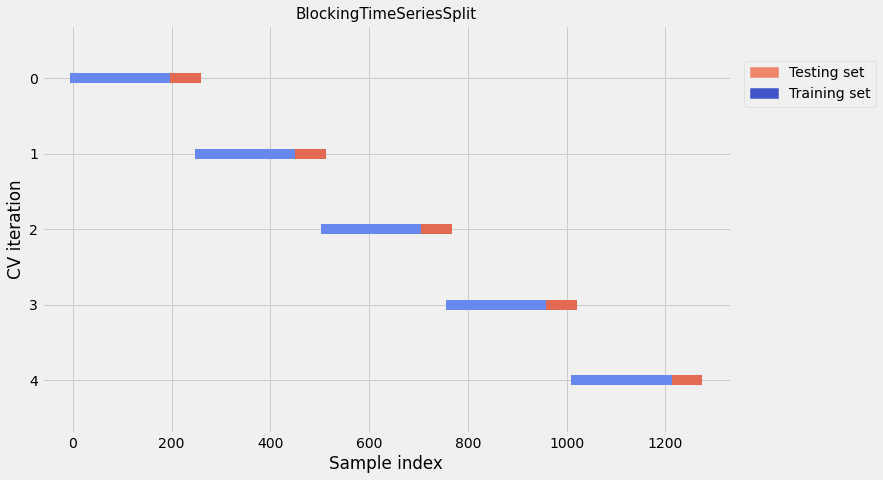

In [196]:
plot_cv_indices(tscv,5, X, y)

In [197]:

for train_index, test_index in tscv.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("Train Start: %d -> End %d" % (train_index[0], train_index[-1]))
    print("Test Start: %d -> End %d" % (test_index[0], test_index[-1]))
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)
    print("#" * 50)

Train Start: 0 -> End 202
Test Start: 203 -> End 253
(203, 11) (203,)
(51, 11) (51,)
##################################################
Train Start: 254 -> End 456
Test Start: 457 -> End 507
(203, 11) (203,)
(51, 11) (51,)
##################################################
Train Start: 508 -> End 710
Test Start: 711 -> End 761
(203, 11) (203,)
(51, 11) (51,)
##################################################
Train Start: 762 -> End 964
Test Start: 965 -> End 1015
(203, 11) (203,)
(51, 11) (51,)
##################################################
Train Start: 1016 -> End 1218
Test Start: 1219 -> End 1269
(203, 11) (203,)
(51, 11) (51,)
##################################################


In [198]:
X_train.shape,X_test.shape

((203, 11), (51, 11))

In [199]:
rf=RandomForestClassifier()

In [200]:
rand_frst_clf = RandomForestClassifier(n_estimators = 200,max_depth=20,min_samples_leaf=3,max_features = "auto",min_samples_split=40, criterion = "gini", bootstrap=True,random_state = 42)

In [201]:

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=3, min_samples_split=40,
                       n_estimators=200, random_state=42)

In [202]:
# Make predictions
y_pred = rand_frst_clf.predict(X_test)

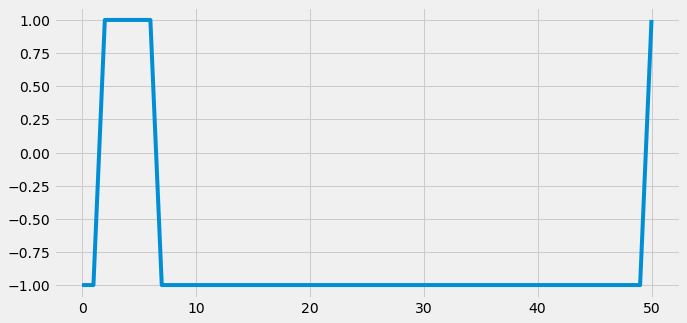

In [203]:
plt.figure(figsize=(10,5))
pd.Series(y_pred).plot();

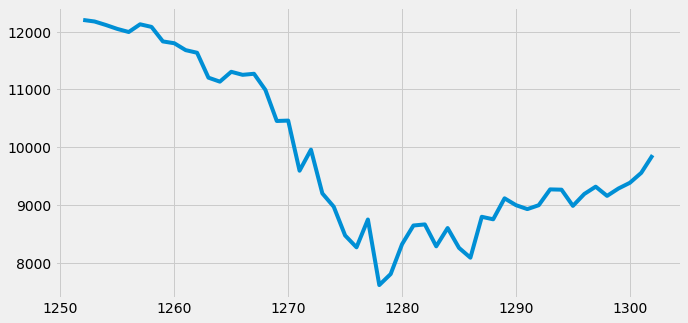

In [204]:
plt.figure(figsize=(10,5))
X_test['adj_close'].plot();

In [205]:
timeseries=pd.concat([X_test['adj_close'].reset_index(),pd.Series(y_pred)],axis=1)

In [206]:
timeseries.columns=['index','close','prediction']

In [207]:
timeseries.set_index('index',inplace=True)

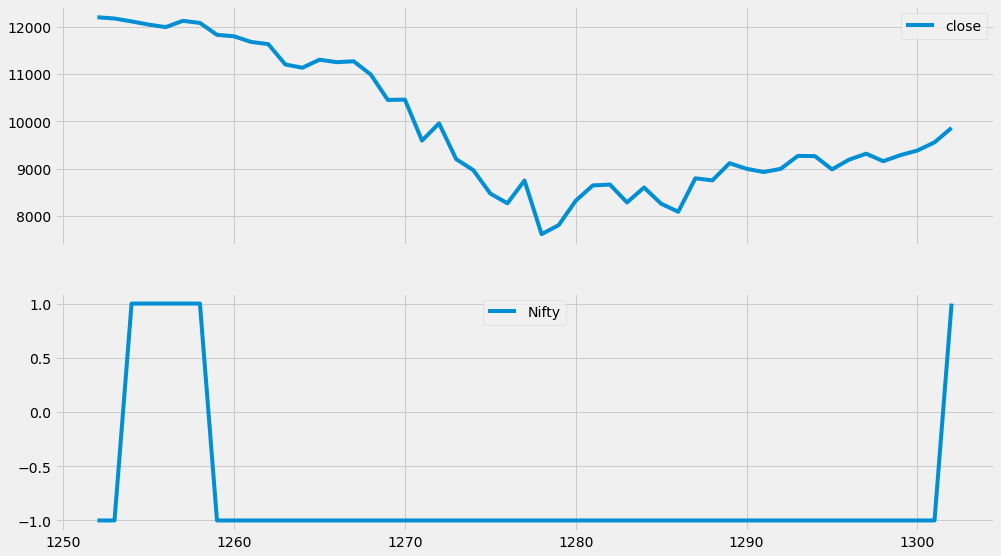

In [208]:
fig, ax = plt.subplots(2,1, figsize=(15,9),sharex=True)
ax[0].plot(timeseries.loc[:, :].index, timeseries.loc[:, 'close'], label='close')
ax[1].plot(timeseries.loc[:, :].index, timeseries.loc[:, 'prediction'], label='Nifty')
ax[0].legend()
ax[1].legend()
plt.show()

In [212]:
data_for_testing=yf.download('^nsei',start='2020-06-01',parse_dates=['Date']).reset_index()

[*********************100%***********************]  1 of 1 completed


In [213]:
data_for_testing['Date']=data_for_testing['Date'].map(dt.datetime.toordinal)

In [214]:
data_for_testing.ta.macd(append=True)
data_for_testing.ta.vortex(append=True)
data_for_testing.ta.aroon(append=True)
print()

In [217]:
predict=rand_frst_clf.predict(data_for_testing[features].dropna())

In [232]:
timeseries=pd.concat([data_for_testing['adj_close'].dropna()[-len(predict):].reset_index(),pd.Series(predict)],axis=1)

In [234]:
timeseries.columns=['index','adj_close','predict']

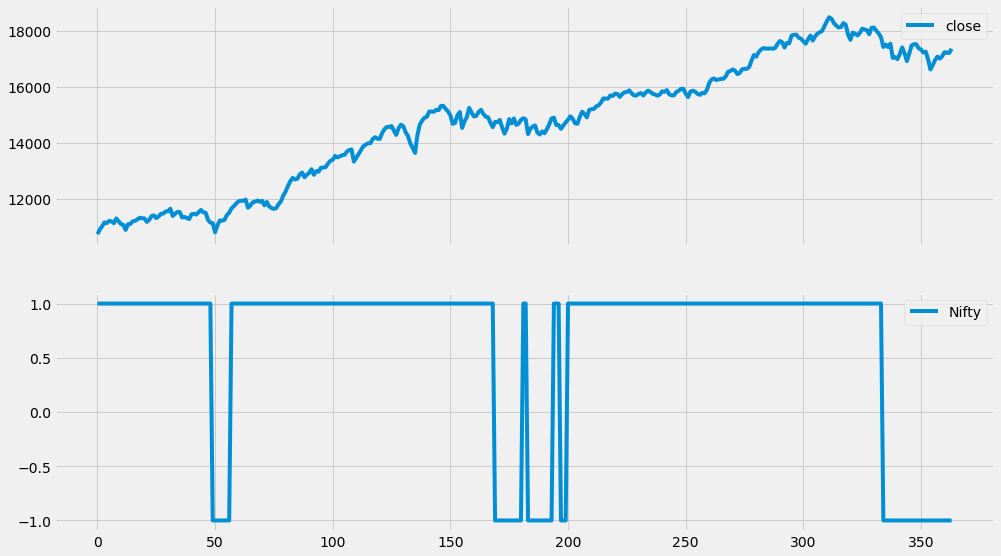

In [235]:
fig, ax = plt.subplots(2,1, figsize=(15,9),sharex=True)
ax[0].plot(timeseries.loc[:, :].index, timeseries.loc[:, 'adj_close'], label='Nifty')
ax[1].plot(timeseries.loc[:, :].index, timeseries.loc[:, 'predict'], label='Prediction')
ax[0].legend()
ax[1].legend()
plt.show()